In [1]:
import sys
import os
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.insert(0, os.path.join(project_root,"src"))
sys.path.insert(0, project_root)

import gf_selection

In [2]:
pdcs = 0.02  # accepted rate of decompression sickness (DCS)
he_percentage = 0
o2_percentage = 21

In [3]:
T_values = np.concatenate((np.arange(20, 40, 10), np.arange(40, 200, 20)))
D_values = np.arange(14, 52, 2)
# o2_values = np.linspace(18, 36, 5)
o2_values = [21]
pdcs_values = [0.02]

combinations = [
    (T, D, o2, pdcs) 
    for T in T_values
    for D in D_values
    for o2 in o2_values
    for pdcs in pdcs_values
]
df = pd.DataFrame(combinations, columns=['T', 'D', 'o2', 'pdcs'])

In [4]:
df['prt'] = df['D']/10+1 * np.sqrt(df['T'])
df['TDT'] = df.apply(lambda x: gf_selection.get_standair_tdt(x['D'], x['T'], x['pdcs']), axis=1)
df['prt'] = (df['D']/10+1) * np.sqrt(df['T'])

In [5]:
df = gf_selection.parallelize_dataframe(df, gf_selection.fit_gf_to_tdt_df)

Text(0, 0.5, 'GF high')

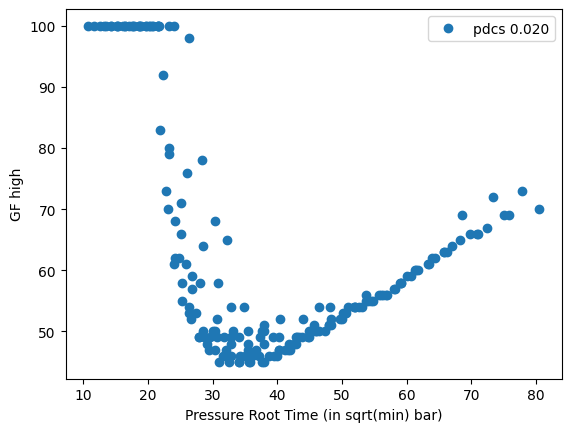

In [6]:
ax = plt.gca()
for pdcs, data in sorted(df.groupby('pdcs'), key=lambda x: x[0], reverse=True):
    data.plot('prt', 'gf_high', marker="o", linewidth=0, label=f"pdcs {pdcs:.3f}", ax=ax)
plt.legend(loc='upper right')
plt.xlabel('Pressure Root Time (in sqrt(min) bar)')
plt.ylabel('GF high')

In [7]:
pivot = df.pivot(index='D', columns='T', values='gf_high').reset_index()

P_inert_gas = (pivot['D']/10 + 1)*0.79

pivot['D_32'] = ((P_inert_gas/(1 - 0.32) - 1)*10).astype(int)
pivot['D_36'] = ((P_inert_gas/(1 - 0.36) - 1)*10).astype(int)
pivot.loc[(pivot['D_32']/10+1)*0.32 > 1.4, 'D_32'] = -1
pivot.loc[(pivot['D_36']/10+1)*0.36 > 1.4, 'D_36'] = -1
depth_columns = ['D', 'D_32', 'D_36']
columns = depth_columns + [col for col in pivot.columns if col not in depth_columns]
pivot = pivot[columns]

In [8]:
def apply_custom_styles(styler):
    styler.map(lambda val: 'background-color: black; color: white', subset=pivot.columns[:3])
    # styler.map(lambda val: 'background-color: lightblue', subset=pivot.columns[3:])
    
    styler.set_table_styles([{
        'selector': 'th', 
        'props': [('border-right', '1px solid black')]}, 
        {'selector': 'td', 
         'props': [('border-right', '1px solid black')]},
    ], axis=1)

    return styler

# Replace index with whitespace
pivot.columns.name = ""
pivot.index = [' '*i for i in range(len(pivot))]
pivot['D_32'] = pivot['D_32'].astype(str).replace("-1", "")
pivot['D_36'] = pivot['D_36'].astype(str).replace("-1", "")
pivot = pivot.rename({
    'D': 'AIR',
    'D_32': 'EAN32',
    'D_36': 'EAN36',
}, axis=1)
styled_pivot = pivot.style.pipe(apply_custom_styles)
HTML(styled_pivot.to_html(index=False))

,AIR,EAN32,EAN36,20,30,40,60,80,100,120,140,160,180
,14,17,19,100,100,100,100,100,100,98,78,68,65
,16,20,22,100,100,100,100,100,76,64,58,54,54
,18,22,24,100,100,100,100,71,58,52,50,50,50
,20,24,27,100,100,100,80,57,50,48,48,48,49
,22,27,,100,100,100,62,49,47,46,50,52,49
,24,29,,100,100,100,53,50,49,49,47,49,51
,26,31,,100,100,73,49,46,46,46,48,50,52
,28,,,100,100,61,47,45,45,47,49,51,54
,30,,,100,83,55,45,45,46,49,50,53,55
,32,,,100,70,52,45,45,47,50,52,54,56
